# Setup


In [1]:
import os

os.chdir("/content")

repo_dir = "rg_sound_generation"
if not os.path.exists(repo_dir):
  !git clone https://github.com/TheSoundOfAIOSR/$repo_dir

os.chdir(repo_dir)
os.chdir('mapping_models')
!python -m pip -q install -e .
#os.chdir('examples')

Cloning into 'rg_sound_generation'...
remote: Enumerating objects: 707, done.
remote: Counting objects: 100% (707/707), done.
remote: Compressing objects: 100% (471/471), done.
remote: Total 707 (delta 356), reused 514 (delta 197), pack-reused 0
Receiving objects: 100% (707/707), 52.98 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (356/356), done.
     |████████████████████████████████| 174kB 7.7MB/s 
     |████████████████████████████████| 3.6MB 13.5MB/s 
     |████████████████████████████████| 3.9MB 47.7MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 
     |████████████████████████████████| 215kB 41.5MB/s 
     |████████████████████████████████| 20.2MB 88.2MB/s 
     |████████████████████████████████| 378kB 46.0MB/s 
     |████████████████████████████████| 5.6MB 22.7MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 


In [7]:
!pip install keras-tcn

     |████████████████████████████████| 706kB 6.0MB/s 


In [2]:
%matplotlib inline

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ddsp.training
import gin

from ddsp.training.preprocessing import F0LoudnessPreprocessor
from mapping_models.trainer import create_dataset
from IPython.display import Audio

os.chdir("/content/rg_sound_generation/mapping_models/examples")

import z_generator
import causal_conv_test

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_dir = '/content/drive/MyDrive/Sound_generation/mapping/complete'
set_name = 'test'
batch_size = 1
#z_model_checkpoint = '/content/drive/MyDrive/Sound_generation/mapping/cp.ckpt'
mapping_model_checkpoint = '/content/drive/MyDrive/Sound_generation/mapping/checkpoint/cp.ckpt'
gin_file_path = '/content/drive/MyDrive/ddsp_generator/operative_config-30000.gin'
ddsp_model_path = '/content/drive/MyDrive/ddsp_generator'
sr = 16000

# Utility functions
- Feature map
- Get prediction
- Mapping function

In [5]:
def features_map(features):
  note_number = features['note_number']
  velocity = features['velocity']
  instrument_source = features['instrument_source']
  qualities = features['qualities']
  f0_scaled = features['f0_scaled']
  ld_scaled = features['ld_scaled']
  z = features['z']

  sequence_length = f0_scaled.shape[0]

  def convert_to_sequence(feature):
    channels = feature.shape[0]
    feature = tf.expand_dims(feature, axis=0)

    feature = tf.broadcast_to(feature, shape=(sequence_length, channels))
    feature = tf.cast(feature, dtype=tf.float32)
    
    return feature

  # Normalize data
  # 0-127
  note_number = note_number / 127
  velocity = velocity / 127

  # 0-2
  # 0	acoustic, 1	electronic, 2	synthetic
  instrument_source = instrument_source / 2

  # Prepare dataset for a sequence to sequence mapping
  note_number = convert_to_sequence(note_number)
  velocity = convert_to_sequence(velocity)
  instrument_source = convert_to_sequence(instrument_source)
  qualities = convert_to_sequence(qualities)

  f0_scaled = tf.expand_dims(f0_scaled, axis=-1)
  f0_variation = f0_scaled * 127.0 - tf.cast(note_number, dtype=tf.float32)
  f0_variation = tf.clip_by_value(f0_variation, -1.0, 1.0)
  #f0_variation = tf.expand_dims(f0_variation, axis=-1)

  ld_scaled = tf.expand_dims(ld_scaled, axis=-1)
  z = tf.reshape(z, shape=(sequence_length, 16))

  input = tf.concat(
      [note_number, velocity, instrument_source, qualities, z],
      axis=-1)
  
  output = tf.concat(
      [f0_variation, ld_scaled],
      axis=-1)
  # print(f'f0_variation shape: {f0_variation}' )
  # print(f'f0_scaled shape: {f0_scaled}' )

  return (input, output)


In [6]:
def map_func(features):
    inputs, outputs = features_map(features)
    return inputs, outputs, features


dataset = create_dataset(
    dataset_dir=dataset_dir,
    split=set_name,
    batch_size=batch_size,
    map_func=map_func
)

datagen = iter(dataset)

In [8]:
from tcn import TCN, tcn_full_summary
tcn_layer = TCN(input_shape=(1000, 29), return_sequences=True, nb_filters=64, kernel_size=8,nb_stacks=2)

mapping_model = tf.keras.models.Sequential([
                                  tcn_layer,
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(16, return_sequences=True),
    tf.keras.layers.Dense(2, activation='tanh')
])



_ = mapping_model.load_weights(mapping_model_checkpoint)


gin.parse_config_file(gin_file_path)
ddsp_model = ddsp.training.models.Autoencoder(encoder=None)
ddsp_model.restore(ddsp_model_path)


In [9]:
def get_preds(inputs, targets, features, num_targets):

  outputs = mapping_model.predict(inputs)
  # outputs = mapping_model(inputs)

  f0_variation_pred = outputs[:, :, 0]
  ld_scaled_pred = outputs[:, :, 1]
  # z_pred = outputs[:, :, 2:]

  f0_variation_pred = tf.squeeze(f0_variation_pred)
  ld_scaled_pred = tf.squeeze(ld_scaled_pred)
  # z_pred = tf.squeeze(z_pred)

  f0_scaled = np.squeeze(features['f0_scaled'])
  ld_scaled = np.squeeze(features['ld_scaled'])
  # z = tf.reshape(features['z'], shape=z_pred.shape)

  note_number = features['note_number']
  note_number = tf.squeeze(tf.cast(note_number, dtype=tf.float32))

  f0_variation = f0_scaled * 127.0 - note_number
  f0_variation *= tf.cast(tf.math.less_equal(tf.math.abs(f0_variation), 1.0),
                            dtype=tf.float32)

  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(f0_variation, label='f0_variation')
  plt.plot(f0_variation_pred, label='f0_variation prediction')
  plt.xlabel('time')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(ld_scaled, label='ld_scaled')
  plt.plot(ld_scaled_pred, label='ld_scaled prediction')
  plt.xlabel('time')
  plt.legend()

  # plt.subplot(2, 2, 3)
  # plt.xlabel('time')
  # plt.ylabel('z')
  # plt.plot(z)
  # plt.ylim([-7., 7.])

  # plt.subplot(2, 2, 4)
  # plt.xlabel('time')
  # plt.ylabel('z prediction')
  # plt.plot(z_pred)
  # plt.ylim([-7., 7.])

  plt.show()

  f0_scaled_pred = (f0_variation_pred + note_number) / 127.0

  f0_scaled_pred = tf.expand_dims(f0_scaled_pred, axis=0)
  ld_scaled_pred = tf.expand_dims(ld_scaled_pred, axis=0)

  # Update the features with predicted f0 and ld
  features['f0_scaled'] = tf.convert_to_tensor(f0_scaled_pred)
  features['ld_scaled'] = tf.convert_to_tensor(ld_scaled_pred)

  f0_hz, loudness_db = F0LoudnessPreprocessor.invert_scaling(
      f0_scaled_pred, ld_scaled_pred)

  features['f0_hz'] = f0_hz
  features['loudness_db'] = loudness_db
  z = features['z']
  z = tf.reshape(z, [1,1000,16])
  features['z'] = z
  # features['z'] = z_pred

  for k, v in features.items():
    print(k, v.numpy().shape)

  ddsp_outputs = ddsp_model(features, training=False)
  audio_pred = ddsp_model.get_audio_from_outputs(ddsp_outputs)

  return features['audio'], audio_pred

In [10]:
inputs, targets, features = next(datagen)
print(features['sample_name'])

tf.Tensor([[b'guitar_acoustic_010-066-100']], shape=(1, 1), dtype=string)


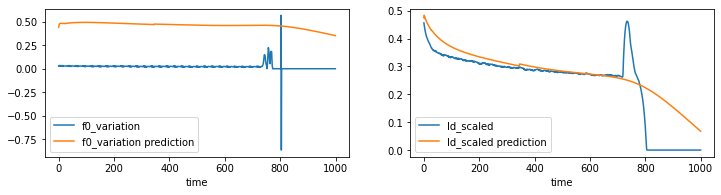

audio (1, 64000)
f0_confidence (1, 1000)
f0_hz (1, 1000)
f0_scaled (1, 1000)
instrument_source (1, 1)
ld_scaled (1, 1000)
loudness_db (1, 1000)
note_number (1, 1)
qualities (1, 10)
sample_name (1, 1)
velocity (1, 1)
z (1, 1000, 16)


In [11]:
audio, audio_pred = get_preds(inputs, targets, features, num_targets=100)


# Audio Output

In [12]:
print('Original Audio')
Audio(audio, rate=sr)

Original Audio


In [13]:
print('Predicted Audio')
Audio(audio_pred, rate=sr)

Predicted Audio
